# Select best window size

In [1]:
library(dplyr)
library(tidyr)
library(purrr)
library(ggpubr)
library(furrr)
library(ggplot2)
library(ggsci)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: future



### Load data

In [4]:
all.files<-list.files("../output/rbp_models/performance_reports/",full.names = T)
perf<-future_map_dfr(.x = all.files,.f = function(file){
    d<-data.table::fread(file,header = T,data.table = F) %>%
       mutate(event_type=as.character(event_type),
             cancer=as.character(cancer))
    return(d)
})

In [5]:
head(perf)

,event_type,cancer,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD,stage,R,n,windowSize
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
1,A3,BLCA,0.7569493,0.001800491,0.5528091,0.03364611,0.0032532834,0.018501270,training,0.04243219,3640,100
2,A3,BLCA,0.7523072,0.001508090,0.5541699,0.01614347,0.0008387876,0.007068195,testing,0.03883413,14559,100
3,A3,BLCA,0.7443405,0.003695531,0.5467834,0.02063730,0.0038527700,0.011130883,training,0.06079088,3640,200
4,A3,BLCA,0.7522558,0.002321126,0.5548591,0.01820070,0.0014025218,0.007592517,testing,0.04817807,14559,200
5,A3,BLCA,0.7573790,0.001990787,0.5573290,0.04416325,0.0019436124,0.023125312,training,0.04461824,3640,50
6,A3,BLCA,0.7533647,0.001093382,0.5551061,0.01472529,0.0016630963,0.007778721,testing,0.03306632,14559,50


In [6]:
events_used<-c("SE","A3","A5","MX","RI","AF","AL")

In [7]:
g<-perf %>%
    mutate(windowSize=factor(windowSize,levels=c("50","100","200")),
           event_type=factor(event_type,levels=events_used))%>%
    filter(stage=="testing") %>%
    ggplot(.,aes(x=windowSize,y=R,group=stage,color=event_type))+
        geom_hline(yintercept = 0.1,linetype="dashed",color="grey",linewidth=0.25)+
        geom_line(aes(linetype=stage))+
        geom_point(size=0.5)+
        scale_y_continuous(breaks = seq(0,0.4,0.05))+
        facet_grid(~cancer~event_type,scales="free_y",space="free")+
        theme_pubr()+
        theme(axis.text.x = element_text(angle=90),
              axis.text.y = element_text(size=8))+
        theme(strip.background = element_blank(),
              strip.text.y=element_text(face="bold"),
              strip.text.x=element_blank())+
        scale_color_locuszoom()+
        guides(color=guide_legend(nrow=1))+
        labs(color="event",linetype="step",x="Sequence window size")

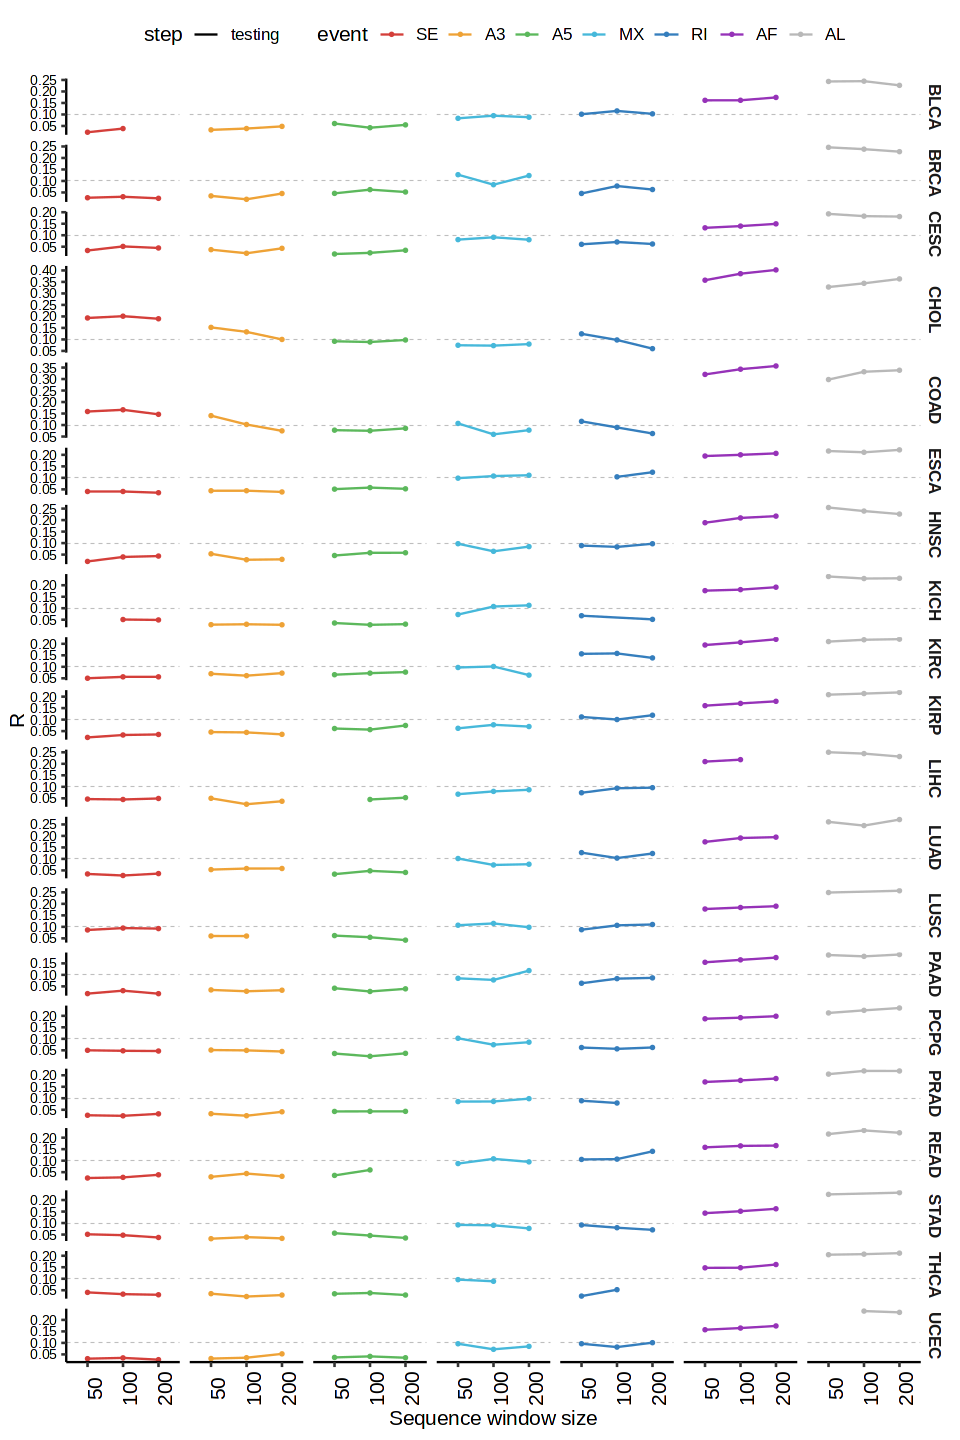

In [8]:
options(repr.plot.width=8,repr.plot.height=12)
g

### Find the optimal window size

In [38]:
perf %>%
group_by(event_type,cancer) %>%
filter(R==max(R),stage=="testing") %>%
group_by(windowSize) %>%
summarize(ncancers=length(cancer),
          mean_r=mean(R))

windowSize,ncancers,mean_r
<int>,<int>,<dbl>
50,18,0.1409084
100,8,0.1787705
200,45,0.1788049
